# [Kaggle_HR analytics](https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists)

In [17]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus']=False

## EDA 및 전처리

In [18]:
# train dataset 불러오기
train = pd.read_csv(os.getcwd() + '/data/hr_analytics/aug_train.csv')
display(train.head())
print(train.shape)
print(train.info())

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


(19158, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), o

In [19]:
# 결측치 확인
train.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [20]:
train.isna().sum().index

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [21]:
# 결측치 대체
from scipy import stats
import statistics

# 결측치를 최빈값으로 대체하는 함수
def replace_with_mode(column):
    mode_value = statistics.mode(column)
    column.fillna(mode_value, inplace=True)
    return column

# 결측치가 있는 컬럼 선택 후 최빈값으로 대체
missing_features = ['gender', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 
                    'company_size', 'company_type', 'last_new_job']
for feature in missing_features:
    train[feature] = replace_with_mode(train[feature])

train.isna().sum() # 결측치 여부 확인

enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline             0
experience                   0
company_size              5938
company_type                 0
last_new_job                 0
training_hours               0
target                       0
dtype: int64

In [22]:
# company_size 결측치 대체(최빈값)
train.loc[train['company_size'].isna(), 'company_size'] = train['company_size'].value_counts().index[0]

In [23]:
train.isna().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

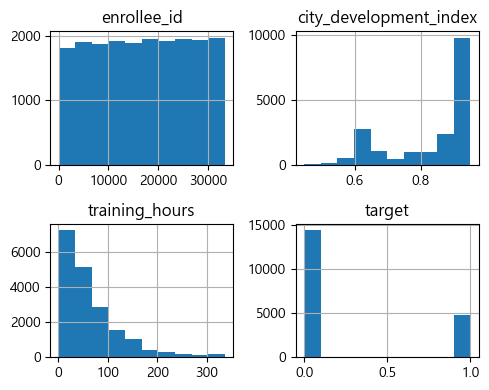

In [24]:
train.hist(figsize=(5,4))
plt.tight_layout();

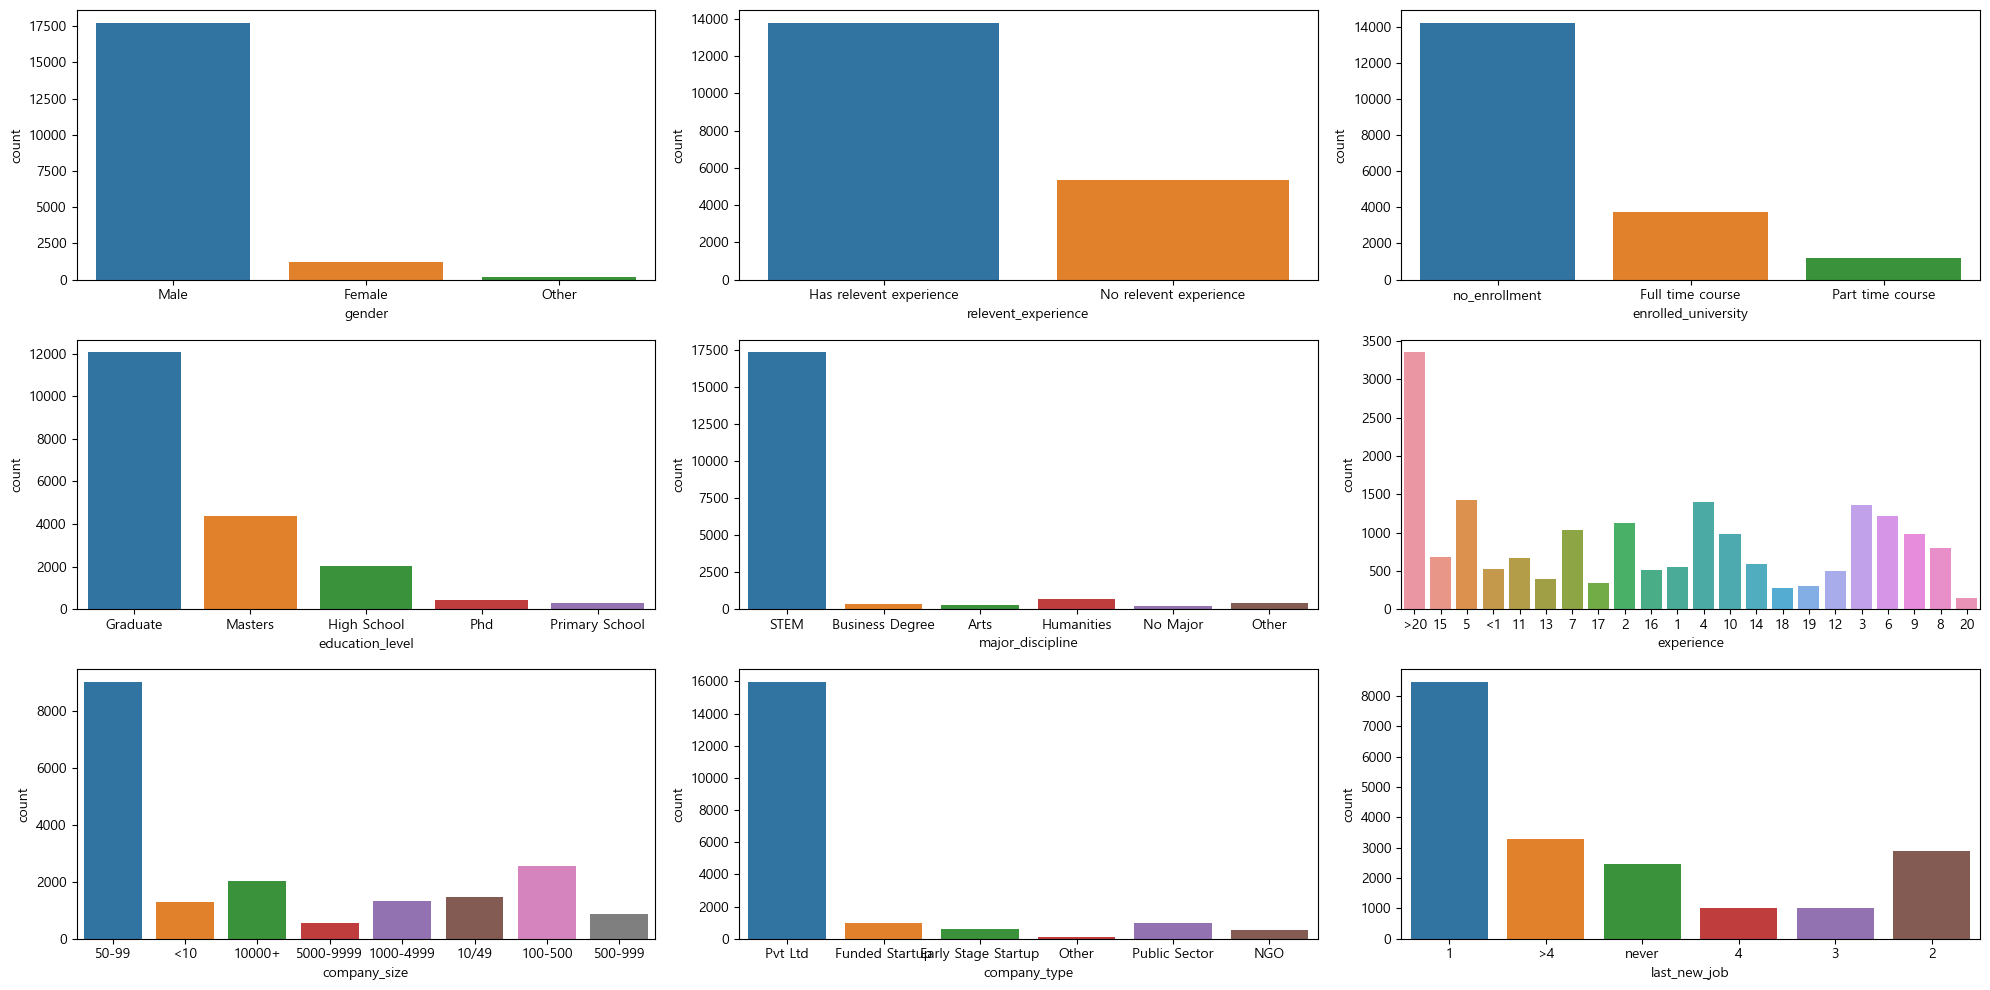

In [25]:
cate_features = train.select_dtypes(include='object').drop('city', axis=1).columns
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(20,10))
for i, feature in zip(range(9), cate_features):
    row = int(i/3)
    col = i%3
    sns.countplot(data=train, x = feature, ax=ax[row][col])
plt.tight_layout();

In [26]:
# gender 'Ohter' 전처리
train.loc[train['gender']=='Other', 'gender'] = 'Female'

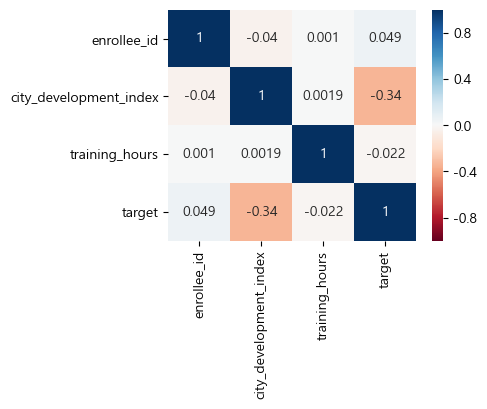

In [27]:
# 상관계수 히트맵
train_corr = train.corr()
plt.figure(figsize=(4,3))
sns.heatmap(train_corr, vmin=-1, vmax=1, annot=True, cmap='RdBu');

## 통계 분석
### 1) t-test(모분산 모름, 유의수준 5%)
- 귀무가설: 성별에 따라 training hours에 차이가 없다.
- 대립가설: 성별에 따라 training hours에 차이가 있다.

In [28]:
import scipy.stats as stats
np.random.seed(123)
male = np.random.choice(train.loc[train['gender']=='Male', 'training_hours'], 24)
female = np.random.choice(train.loc[train['gender']=='Female', 'training_hours'], 24)

# 정규성 검정
stats.shapiro(male) # 정규성 만족 못 함
stats.shapiro(female) # 정규성 만족 함
print('t-test 결과', stats.ttest_ind(male, female)) # 귀무가설 채택

# 신뢰구간
def sp(data1, data2):
    df = len(data1) + len(data2) - 2
    s1 = (len(data1)-1) * (data1.std()**2)
    s2 = (len(data2)-1) * (data2.std()**2)
    sp = np.sqrt((s1+s2)/df)
    return sp

alpha=0.95
dof = len(male) + len(female) - 2
diff_mean = np.mean(male) - np.mean(female)
s = sp(male, female)*(1/len(male) + 1/len(female))
ci = stats.t.interval(alpha, dof, loc=diff_mean, scale=s)
print('신뢰구간: ', ci)

t-test 결과 Ttest_indResult(statistic=-0.9170362252946058, pvalue=0.36390673555260666)
신뢰구간:  (-15.662908984471516, -3.670424348861813)


### 2) 교차 검증
- 귀무가설: 회사 규모와 이직 여부 간에 상관성이 없다.
- 대립가설: 회사 규모와 이직 여부 간에 상관성이 있다.

In [35]:
tab = pd.crosstab(train['company_size'], train['target'])
chi, p, dof, expects = stats.chi2_contingency(tab)
print(f'검정통계량: {round(chi, 4)} / p-value: {round(p, 4)}')

검정통계량: 592.9642 / p-value: 0.0


## 머신러닝
### 1) 모델 구현

In [57]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler

# 필요없는 변수 제거
df = train.drop(['enrollee_id', 'city'], axis=1)

# 원핫인코딩
le = LabelEncoder()
features = ['gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience',
           'company_size', 'company_type', 'last_new_job', 'training_hours']
for feature in features:
    df[feature] = le.fit_transform(df[feature])

# 오버샘플링
X = df.drop('target', axis=1)
y = df.target
sm = SMOTE(random_state=123)
X_sm, y_sm = sm.fit_resample(X, y)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=123, stratify=y_sm)
print('오버샘플링 전: \n', pd.Series(y).value_counts())
print('오버샘플링 후: \n', pd.Series(y_sm).value_counts())

오버샘플링 전: 
 0.0    14381
1.0     4777
Name: target, dtype: int64
오버샘플링 후: 
 0.0    14381
1.0    14381
dtype: int64


In [73]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time

# 모델 구현
def make_model(model):
    start = time.time()
    model.fit(X_train, y_train)
    end=time.time()
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_pred, y_test)
    rmse = round(np.sqrt(mse), 4)
    r2 = round(r2_score(y_pred, y_test), 4)
    mae = round(mean_absolute_error(y_pred, y_test), 4)
    print(f'##{model.__class__.__name__}##')
    print('R2 Score: ', r2)
    print('RMSE: ', rmse)
    print('MAE: ', mae)
    print('time: ', round(end-start, 4), 'sec')
    
# 모델 객체 생성
rfr_clf = RandomForestClassifier(random_state=123)
ext_clf = ExtraTreesClassifier(random_state=123)
bag_clf = BaggingClassifier(random_state=123)
xgb_clf = XGBClassifier(random_state=123)
lgbm_clf = LGBMClassifier(random_state=123)

In [74]:
for model in [rfr_clf, ext_clf, bag_clf, xgb_clf, lgbm_clf]:
    make_model(model)
    print('-'*20)

##RandomForestClassifier##
R2 Score:  0.3548
RMSE:  0.4012
MAE:  0.161
time:  3.5375 sec
--------------------
##ExtraTreesClassifier##
R2 Score:  0.3307
RMSE:  0.4088
MAE:  0.1671
time:  3.2771 sec
--------------------
##BaggingClassifier##
R2 Score:  0.2688
RMSE:  0.4259
MAE:  0.1814
time:  0.8723 sec
--------------------
[11:36:11] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
##XGBClassifier##
R2 Score:  0.379
RMSE:  0.393
MAE:  0.1545
time:  1.9482 sec
--------------------
##LGBMClassifier##
R2 Score:  0.3771
RMSE:  0.3942
MAE:  0.1554
time:  0.6217 sec
--------------------


### 2) 예측값 생성

In [79]:
test = pd.read_csv(os.getcwd() + '/data/hr_analytics/aug_test.csv')
display(test.head())
print(test.info())
print(test.shape)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB
None
(2129, 13)


In [80]:
test.isna().sum()

enrollee_id                 0
city                        0
city_development_index      0
gender                    508
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
company_size              622
company_type              634
last_new_job               40
training_hours              0
dtype: int64

In [81]:
# 결측치가 있는 컬럼 선택 후 최빈값으로 대체
missing_features = ['gender', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 
                    'company_size', 'company_type', 'last_new_job']
for feature in missing_features:
    test[feature] = replace_with_mode(test[feature])

# company_size 결측치 대체(최빈값)
test.loc[test['company_size'].isna(), 'company_size'] = test['company_size'].value_counts().index[0]
    
test.isna().sum() # 결측치 여부 확인

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
dtype: int64

In [84]:
test.gender.value_counts()

Male      1968
Female     137
Other       24
Name: gender, dtype: int64

In [85]:
# gender 'Ohter' 전처리
test.loc[test['gender']=='Other', 'gender'] = 'Female'

In [87]:
# 필요없는 변수 제거
test1 = test.drop(['enrollee_id', 'city'], axis=1)

# 원핫인코딩
le = LabelEncoder()
features = ['gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience',
           'company_size', 'company_type', 'last_new_job', 'training_hours']
for feature in features:
    test1[feature] = le.fit_transform(test1[feature])

In [91]:
# 예측값 생성
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(test1)
print(y_pred[:10])

[11:59:50] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [95]:
submission = pd.read_csv(os.getcwd() + '/data/hr_analytics/sample_submission.csv')
# submission.head(2)
submission['target'] = y_pred
submission.head(3)
submission.to_csv(os.getcwd() + '/data/hr_analytics/result.csv', index=False)